In [2]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from typing import Union, Tuple, Optional
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO
from src.losses.data_losses import LpLoss, H1Loss
from src.training.adamw import AdamW

In [3]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    print(f['density'].shape)
    print(f.keys())

(8001, 64, 64)
<KeysViewHDF5 ['density', 'energy', 'enstrophy', 'enstrophy_phi', 'gamma_c', 'gamma_n', 'gamma_n_spectral', 'kinetic_energy', 'omega', 'phi', 'state_density', 'state_omega', 'state_phi', 'thermal_energy', 'time']>


In [7]:
def load_h5_pair(input_file: str, target_file: str, device: torch.device,
                 derived: bool = False) -> Union[Tuple[torch.Tensor, torch.Tensor],
                                                 Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
    """
    Loads input and target data from HDF5 files.

    :param input_file: Path to the input file.
    :param target_file: Path to the target file.
    :param device: Torch device.
    :param derived: Whether to load the derived gamma_n quantity.
    :return: Tuple of (x, y) if not derived; otherwise (x, y, gamma_n).
    """
    def load_data(file: str) -> torch.Tensor:
        with h5py.File(file, 'r') as f:
            density = f['density'][:]
            omega = f['omega'][:]
            phi = f['phi'][:]
            # Stack along channel dimension and add a batch dimension.
            data = torch.tensor(np.stack((density, omega, phi), axis=1), dtype=torch.float32)
            # Rearranging dimensions as needed: (B, var_dim, T, H, W)
            return data.unsqueeze(0).permute(0, 2, 1, 3, 4)

    x = load_data(input_file)
    y = load_data(target_file)
    gamma_n: Optional[torch.Tensor] = None

    if derived:
        with h5py.File(target_file, 'r') as f:
            gamma_n = torch.tensor(f['gamma_n'][:], dtype=torch.float32)

    if derived:
        assert gamma_n is not None  # For type-checkers.
        return x.to(device), y.to(device), gamma_n.to(device)
    else:
        return x.to(device), y.to(device)
# Gather HDF5 file pairs.
input_pattern = "../data/input*.h5"
target_pattern = "../data/target*.h5"
input_files = sorted(glob.glob(input_pattern))
target_files = sorted(glob.glob(target_pattern))
paired_files = list(zip(input_files, target_files))
random.shuffle(paired_files)
split_idx = int(.8 * len(paired_files))
train_files = paired_files[:split_idx]
test_files = paired_files[split_idx:]
for (input_file, target_file) in train_files:
    data = load_h5_pair(input_file, target_file, 'cpu')

In [5]:
modes = [(16,16), (32,32), (8,8)]
model = DQFNO(
    modes=modes,
    in_channels=1,
    out_channels=1,
    hidden_channels=64,
)
model.cpu()
lpLoss= LpLoss(d=4,p=2, reduction='mean')
h1Loss = H1Loss(d=2)
# optim = AdamW(model.parameters(), lr = .00001)
optim = torch.optim.Adam(model.parameters(), lr=.0001)

In [6]:
# Training loop with global normalization
losses = []
model.train()
for j in range(1):
    for i, (input_file, target_file) in enumerate(train_files):
        optim.zero_grad()
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        
        # Reshape x and y to: Batch, Channels, Time, V, X, Y
        x = x.reshape(1, 1, 10, 3, 64, 64)
        y = y.reshape(1, 1, 10, 3, 64, 64)
        
        # Forward pass through the model.
        x = model(x)
        
        # Compute the loss (MSE loss in this example)
        loss = torch.nn.functional.mse_loss(x, y)
        loss.backward()
        optim.step()
        
        if i % 10 == 0:
            print(f"Lploss: {float(loss)}")
            losses.append(float(loss))

Lploss: 5.066404342651367
Lploss: 5.2204365730285645
Lploss: 5.272134304046631
Lploss: 5.3434882164001465
Lploss: 5.521910667419434
Lploss: 5.423197269439697
Lploss: 5.117234230041504
Lploss: 5.096867084503174
Lploss: 4.688313961029053
Lploss: 4.0865631103515625
Lploss: 2.9770307540893555
Lploss: 2.0545973777770996
Lploss: 1.6476521492004395
Lploss: 1.6593979597091675
Lploss: 1.4634170532226562
Lploss: 1.2642343044281006
Lploss: 1.264182686805725
Lploss: 1.15337336063385
Lploss: 1.2355026006698608
Lploss: 1.0413113832473755
Lploss: 1.0392314195632935
Lploss: 0.9559769034385681
Lploss: 0.9704172611236572
Lploss: 0.9665623307228088
Lploss: 0.8750225305557251
Lploss: 0.9144453406333923
Lploss: 0.776701807975769
Lploss: 0.7578041553497314
Lploss: 0.7135236263275146
Lploss: 0.6729503870010376
Lploss: 0.6948977112770081
Lploss: 0.743400514125824
Lploss: 0.7597091197967529
Lploss: 0.6540965437889099


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../src/data/input_000775.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

tensor(-11.8697) tensor(14.5452) tensor(1.7982e-06)
tensor(-14.2013) tensor(11.7764) tensor(0.0136)
tensor(-12.4727) tensor(14.0027) tensor(0.0038)
tensor(-10.9347) tensor(11.7845) tensor(0.0118)
tensor(-12.4077) tensor(12.4191) tensor(0.0112)
tensor(-12.0653) tensor(13.5438) tensor(0.0088)
tensor(-11.0805) tensor(12.5698) tensor(0.0139)
tensor(-12.7334) tensor(13.8254) tensor(0.0096)
tensor(-10.0648) tensor(11.9869) tensor(0.0030)
tensor(-12.1482) tensor(13.4012) tensor(0.0061)


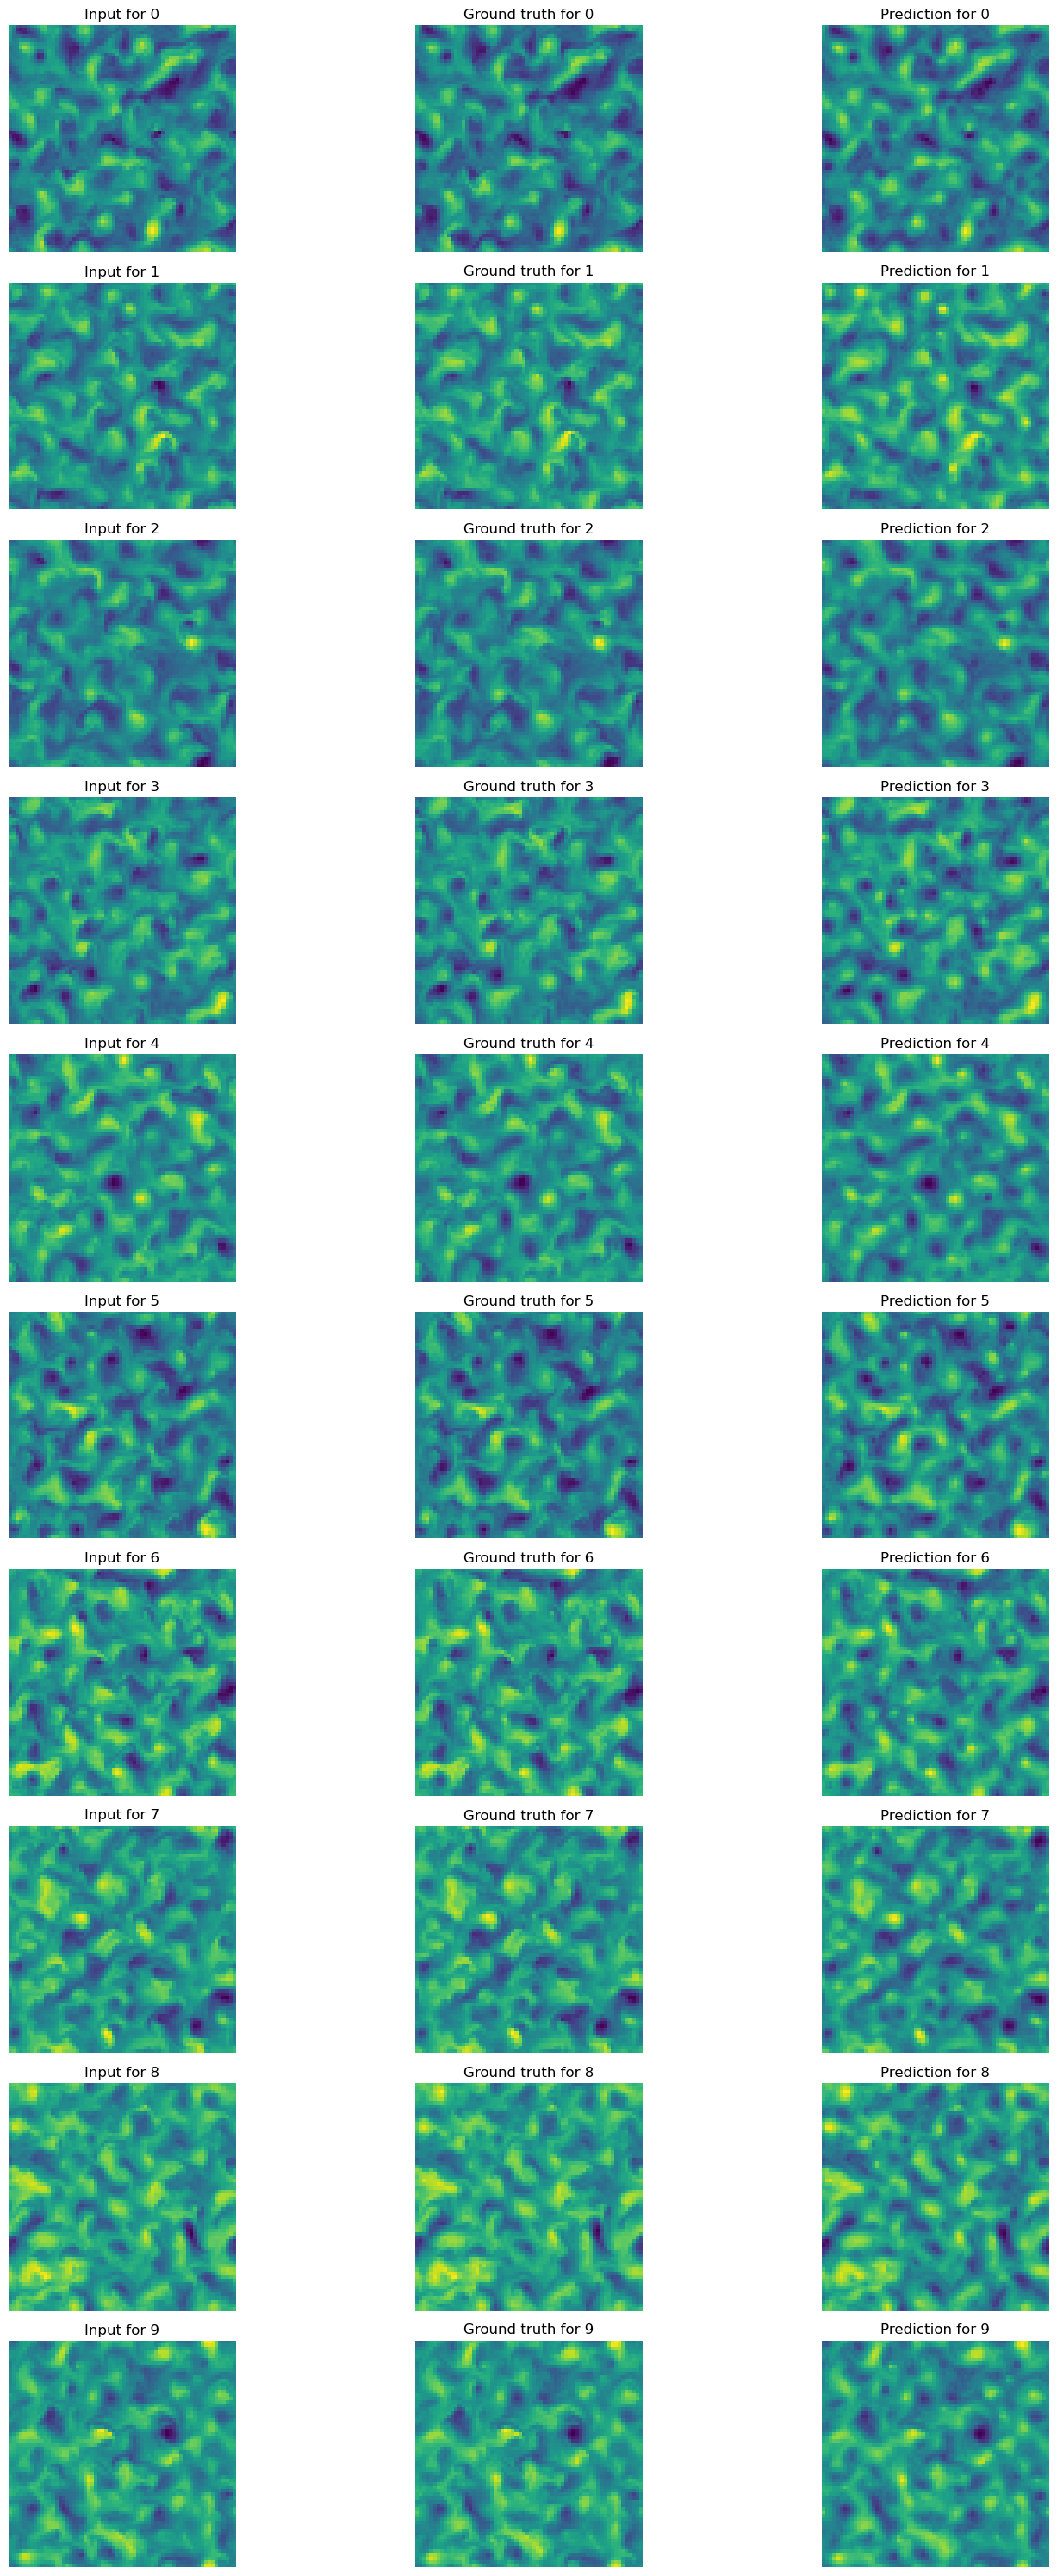

In [8]:
# Test the trained model
with torch.no_grad():
    plots = 10
    fig, ax = plt.subplots(plots,3, figsize=(16,30))

    for i, (input_file, target_file) in enumerate(test_files):
        if i >=plots:
            break
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        x = x.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        y = y.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        pred = model(x)
        print(pred.min(), pred.max(), pred.mean())
        
        x_image = x[0,0,0,1]
        y_image = y[0,0,0,1]
        pred_image = pred[0,0,0,1]
        ax[i,0].imshow(x_image)
        ax[i,0].set_title(f"Input for {i}")
        ax[i,0].axis('off')
        ax[i,1].imshow(y_image)
        ax[i,1].set_title(f"Ground truth for {i}")
        ax[i,1].axis('off')
        ax[i,2].imshow(pred_image)
        ax[i,2].set_title(f"Prediction for {i}")
        ax[i,2].axis('off')

    plt.tight_layout()
    plt.show()